In [1]:
from google.colab import drive
import os

drive.mount('/content/drive')

GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', 'data')
os.chdir(GOOGLE_DRIVE_PATH)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Preparing LeNet model as our classifier for computing scores

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import torch
import torch.nn as nn

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x, return_features=False):
        """
        Defines the forward pass. Can return final logits or intermediate features.

        Args:
            x (torch.Tensor): The input batch of images.
            return_features (bool): If True, returns features from fc1.
                                    If False, returns final logits from fc2.
        """
        x = torch.relu(torch.max_pool2d(self.conv1(x), 2))
        x = torch.relu(torch.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 320)

        features = torch.relu(self.fc1(x))

        if return_features:
            return features

        output = self.fc2(features)
        return output

LeNet()

LeNet(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert image to a [0.0, 1.0] tensor
    transforms.Lambda(lambda x: (x > 0.5).float()) # Binarizes the tensor to 0s and 1s
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
classifier = LeNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=0.001)

In [ ]:
num_epochs = 5

classifier.train()
for epoch in range(num_epochs):
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        outputs = classifier(data)
        loss = criterion(outputs, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (batch_idx+1) % 200 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

print("Finished Training!")

Epoch [1/5], Step [200/938], Loss: 0.2336
Epoch [1/5], Step [400/938], Loss: 0.1033
Epoch [1/5], Step [600/938], Loss: 0.1078
Epoch [1/5], Step [800/938], Loss: 0.0666
Epoch [2/5], Step [200/938], Loss: 0.1797
Epoch [2/5], Step [400/938], Loss: 0.0486
Epoch [2/5], Step [600/938], Loss: 0.0728
Epoch [2/5], Step [800/938], Loss: 0.0410
Epoch [3/5], Step [200/938], Loss: 0.1544
Epoch [3/5], Step [400/938], Loss: 0.0242
Epoch [3/5], Step [600/938], Loss: 0.0752
Epoch [3/5], Step [800/938], Loss: 0.0080
Epoch [4/5], Step [200/938], Loss: 0.0184
Epoch [4/5], Step [400/938], Loss: 0.0784
Epoch [4/5], Step [600/938], Loss: 0.0480
Epoch [4/5], Step [800/938], Loss: 0.0267
Epoch [5/5], Step [200/938], Loss: 0.0087
Epoch [5/5], Step [400/938], Loss: 0.0608
Epoch [5/5], Step [600/938], Loss: 0.0114
Epoch [5/5], Step [800/938], Loss: 0.0314
Finished Training!


In [ ]:
weights_path = 'lenet_mnist.pth'
torch.save(classifier.state_dict(), weights_path)
print(f"Model weights saved to {weights_path}")

Model weights saved to lenet_mnist.pth


In [5]:
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(dataset=test_dataset, batch_size=128, shuffle=False)

In [ ]:
classifier.eval()
correct = 0
total = 0
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        outputs = classifier(data)
        _, predicted = torch.max(outputs.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy of the model on the 10,000 test images: {accuracy:.2f}%')

Accuracy of the model on the 10,000 test images: 98.71%


In [6]:
# to load the weights later:
weights_path = 'lenet_mnist.pth'
classifier = LeNet()
classifier.load_state_dict(torch.load(weights_path))
classifier.eval()

LeNet(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

# Functions for scores

In [7]:
import torch.nn.functional as F
import numpy as np
from torch.utils.data import TensorDataset

In [8]:
def calculate_inception_score(images, classifier, batch_size=32, splits=10):
    """
    Computes the Inception Score for a set of generated images.

    Args:
        images (torch.Tensor): A tensor of generated images, shape (N, 784).
        classifier (nn.Module): A pretrained classifier (e.g., LeNet) for MNIST.
        batch_size (int): The batch size for feeding images to the classifier.
        splits (int): The number of splits to average scores over for stability.

    Returns:
        tuple: (mean_is, std_is) - The mean and standard deviation of the Inception Score.
    """

    classifier.eval()

    images = images.view(-1, 1, 28, 28)


    dataset = TensorDataset(images)
    dataloader = DataLoader(dataset, batch_size=batch_size)

    all_preds = []
    with torch.no_grad():
        for batch in dataloader:

            img_batch = batch[0].to(device)
            preds = F.softmax(classifier(img_batch), dim=1)
            all_preds.append(preds.cpu().numpy())

    all_preds = np.concatenate(all_preds, axis=0)

    scores = []
    n_samples = all_preds.shape[0]
    split_size = n_samples // splits

    for i in range(splits):
        part = all_preds[i * split_size: (i + 1) * split_size, :]

        # Calculate p(y|x) - already have this from softmax
        p_yx = part

        # Calculate p(y) - the marginal distribution
        p_y = np.mean(part, axis=0)

        # Calculate KL divergence D_KL(p(y|x) || p(y)) for each sample
        kl_divs = p_yx * (np.log(p_yx + 1e-10) - np.log(p_y + 1e-10))
        kl_divs = np.sum(kl_divs, axis=1)

        # Average the KL divergences and exponentiate
        mean_kl_div = np.mean(kl_divs)
        is_score = np.exp(mean_kl_div)

        scores.append(is_score)

    return np.mean(scores), np.std(scores)


In [9]:
from sklearn.metrics.pairwise import rbf_kernel

In [10]:
def calculate_kid_gaussian(act1, act2):
    """
    Calculates the Kernel Inception Distance (KID) using a Gaussian (RBF) kernel.

    Args:
        act1 (np.ndarray): A numpy array of feature activations for the real images.
        act2 (np.ndarray): A numpy array of feature activations for the generated images.

    Returns:
        float: The KID score. Lower is better.
    """

    mmd = rbf_kernel(act1, act1).mean() + \
           rbf_kernel(act2, act2).mean() - \
           2 * rbf_kernel(act1, act2).mean()

    return mmd

In [11]:
from scipy.linalg import sqrtm

In [12]:
def calculate_fid(act1, act2):
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
    ssdiff = np.sum((mu1 - mu2)**2.0)
    covmean = sqrtm(sigma1.dot(sigma2))
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

# Model definition of NADE and VAE

In [3]:
class NADE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=512):
        """Initialize the Neural Autoregressive Density Estimation model.

        Args:
            input_dim (int): Dimension of input data (flattened image size)
            hidden_dim (int): Number of units in hidden layer
        """
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.W = nn.Parameter(torch.randn(input_dim, hidden_dim) * 0.01)
        self.c = nn.Parameter(torch.zeros(hidden_dim))
        self.V = nn.Parameter(torch.randn(hidden_dim, input_dim) * 0.01)
        self.b = nn.Parameter(torch.zeros(input_dim))

        # Training metadata
        self.start_epoch = 0
        self.best_loss = float('inf')
        self.train_history = []
        self.test_history = []

    def forward(self, x):
        """Forward pass through the NADE model.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, input_dim)

        Returns:
            tuple: (x_hat, all_h) where:
                x_hat: reconstructed probabilities for each dimension
                all_h: all hidden states during autoregressive process
        """
        batch_size = x.size(0)
        x_hat = torch.zeros_like(x)
        all_h = []

        sum_to_d = torch.zeros(batch_size, self.hidden_dim, device=x.device)

        for d in range(self.input_dim):
            # Compute hidden activation: a_d = c + sum_{k<d} x_k * W_k
            a_d = self.c + sum_to_d
            h_d = torch.sigmoid(a_d)

            # Compute output probability for dimension d:
            # p_d = sigmoid(b_d + V_d^T h_d)
            p_d = torch.sigmoid(self.b[d] + torch.matmul(h_d, self.V[:, d]))

            # Save prediction
            x_hat[:, d] = p_d
            all_h.append(h_d)

            # Update running sum for the next dimension
            sum_to_d += x[:, d].unsqueeze(1) * self.W[d]

        return x_hat, torch.stack(all_h, dim=1)

    def log_prob(self, x):
        """Compute log probability of input samples under the model.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, input_dim)

        Returns:
            torch.Tensor: Log probabilities for each sample (batch_size)
        """
        x_hat, _ = self.forward(x)
        # Compute Bernoulli log likelihood:
        # log p(x) = sum_d [x_d * log(p_d) + (1-x_d) * log(1-p_d)]  --- update this in order to avoid log of zero

        x_hat = torch.clamp(x_hat, min=1e-6, max=1 - 1e-6) # avoid log(0)
        log_prob = x * torch.log(x_hat) + (1 - x) * torch.log(1 - x_hat)
        # Sum over all dimensions (input_dim)
        return log_prob.sum(dim=1)


    def generate_samples(self, num_samples=10):
        """
        Generates new images via ancestral sampling
        Args:
            num_samples: How many images to generate
        Returns:
            Tensor of shape (num_samples, input_dim)
        """
        samples = torch.zeros(num_samples, 784).to(device)
        with torch.no_grad():
            for d in range(784):
                p_d = self.forward(samples)[0][:, d]
                samples[:, d] = torch.bernoulli(p_d)
        return samples.cpu()


In [ ]:
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.enc = nn.Sequential(
            nn.Linear(784, 400),
            nn.ReLU(),
        )
        self.mu = nn.Linear(400, latent_dim)
        self.log_var = nn.Linear(400, latent_dim)

    def forward(self, x):
        h = self.enc(x)
        return self.mu(h), self.log_var(h)

class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.dec = nn.Sequential(
            nn.Linear(latent_dim, 400),
            nn.ReLU(),
            nn.Linear(400, 784),
            nn.Sigmoid(),
        )

    def forward(self, z):
        return self.dec(z)

class VAE(nn.Module):
    def __init__(self, latent_dim=2):
        super().__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, log_var = self.encoder(x)
        z = self.reparameterize(mu, log_var)
        recon_x = self.decoder(z)
        return recon_x, mu, log_var

In [ ]:
def vae_loss(recon_x, x, mu, log_var):
    # Reconstruction Loss:
    # Measures how accurately the decoded output matches the original input.
    recon_loss = torch.nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')

    # KL Divergence Loss:
    # Measures how much the learned latent distribution deviates
    # from a standard Gaussian distribution (prior).
    kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

    # Total loss combines both terms
    loss = recon_loss + kl_loss

    return loss, recon_loss, kl_loss

# Data Preparation

In [16]:
full_test_dataset = test_dataset

all_images = full_test_dataset.data.view(-1, 784).float() / 255.0
all_labels = full_test_dataset.targets

train_images = all_images[0:1000]
train_labels = all_labels[0:1000]

test_images = all_images[1000:2000]
test_labels = all_labels[1000:2000]

print(f"Shape of our new training images: {train_images.shape}")
print(f"Shape of our new testing images:  {test_images.shape}")

train_dataset = TensorDataset(train_images, train_labels)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = TensorDataset(test_images, test_labels)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

Shape of our new training images: torch.Size([1000, 784])
Shape of our new testing images:  torch.Size([1000, 784])


# GMM training & sampling

A Gaussian Mixture Model (GMM) is a solid baseline for generative tasks because it's a true generative model, theoretically it can model complex distributions and also it is simple and fast. </br></br>
GMMs fail to produce high-quality images due to severe limitations:

*   Failure in high dimensions
*   No spatial awareness
*   Restrictive assumptions about the shape of the distribution
*   Sensitivity to the number of defined components

In [17]:
from sklearn.mixture import GaussianMixture

In [ ]:
gmm = GaussianMixture(
    n_components=10,
    covariance_type='diag',
    max_iter=100,
    n_init=10,
    random_state=42,
    verbose=1,
    verbose_interval=10
)

gmm.fit(train_images.numpy())

print(f"\nModel converged: {gmm.converged_}")
print(f"Number of iterations to converge: {gmm.n_iter_}")

In [21]:
print("\nGenerating samples from the fitted GMM...")
gmm_samples, _ = gmm.sample(1000)
print("Sample generation complete.")


Generating samples from the fitted GMM...
Sample generation complete.


## Load and save GMM model and samples

In [13]:
import joblib

In [ ]:
model_filename = 'gmm_model.joblib'
print(f"\nSaving model to {model_filename}...")
joblib.dump(gmm, model_filename)
print("Model saved successfully.")


Saving model to gmm_model.joblib...
Model saved successfully.


In [14]:
model_filename = 'gmm_model.joblib'
print(f"\nLoading model from {model_filename}...")
gmm = joblib.load(model_filename)
print("Model loaded successfully.")


Loading model from gmm_model.joblib...
Model loaded successfully.


In [ ]:
filename = 'gmm_generated_samples.npy'

print(f"\nSaving generated samples to '{filename}'...")

np.save(filename, gmm_samples)

print("Samples saved successfully.")


Saving generated samples to 'gmm_generated_samples.npy'...
Samples saved successfully.


In [22]:
filename = 'gmm_generated_samples.npy'

print(f"\nLoading samples from '{filename}'...")

gmm_samples = np.load(filename)

print("Samples loaded successfully.")


Loading samples from 'gmm_generated_samples.npy'...
Samples loaded successfully.


# Train NADE model

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [7]:
import time

In [ ]:
classifier.eval()

print("Preparing real features for FID calculation...")
with torch.no_grad():

    real_images_for_fid = test_images.view(-1, 1, 28, 28).to(device)

    real_features = classifier(real_images_for_fid, return_features=True).cpu().numpy()

print(f"Real features prepared with shape: {real_features.shape}")

Preparing real features for FID calculation...
Real features prepared with shape: (1000, 50)


In [ ]:
nade = NADE().to(device)
optimizer = optim.Adam(nade.parameters(), lr=1e-4)

num_epochs = 100
train_losses = []
test_losses = []
fid_history = []
time_history = []
epoch_history = []

start_time = time.time()

print("\nStarting NADE training...")

for epoch in range(num_epochs):
    nade.train()
    train_loss = 0
    for batch, _ in train_loader:
        batch = batch.view(-1, 784).to(device)
        optimizer.zero_grad()
        loss = -nade.log_prob(batch).mean()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    nade.eval()
    test_loss = 0
    with torch.no_grad():
        for batch, _ in test_loader:
            batch = batch.view(-1, 784).to(device)
            loss = -nade.log_prob(batch).mean()
            test_loss += loss.item()
    avg_test_loss = test_loss / len(test_loader)
    test_losses.append(avg_test_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.4f} | Test Loss: {avg_test_loss:.4f}")

    if epoch % 5 == 0:
        nade.eval()
        with torch.no_grad():
            generated_samples = nade.generate_samples(num_samples=len(test_images))
            generated_samples = generated_samples.view(-1, 1, 28, 28).to(device)

            fake_features = classifier(generated_samples, return_features=True).cpu().numpy()

            fid_score = calculate_fid(real_features, fake_features)

            fid_history.append(fid_score)
            elapsed_time = time.time() - start_time
            time_history.append(elapsed_time)
            epoch_history.append(epoch + 1)

            print(f"--- Epoch {epoch+1} Evaluation ---")
            print(f"FID Score: {fid_score:.4f}")
            print(f"Time Elapsed: {elapsed_time:.2f} seconds")
            print("--------------------------")

print("\nTraining complete!")
print("Epochs recorded:", epoch_history)
print("FID History:", fid_history)
print("Time History:", time_history)


Starting NADE training...
Epoch [1/100] - Train Loss: 492.0232 | Test Loss: 437.2212
--- Epoch 1 Evaluation ---
FID Score: 0.0299
Time Elapsed: 122.24 seconds
--------------------------
Epoch [2/100] - Train Loss: 399.0838 | Test Loss: 358.8697
Epoch [3/100] - Train Loss: 333.4977 | Test Loss: 305.9437
Epoch [4/100] - Train Loss: 290.5002 | Test Loss: 272.2928
Epoch [5/100] - Train Loss: 263.2215 | Test Loss: 251.2040
Epoch [6/100] - Train Loss: 246.5543 | Test Loss: 237.7082
Failed to find a square root.
--- Epoch 6 Evaluation ---
FID Score: nan
Time Elapsed: 279.06 seconds
--------------------------
Epoch [7/100] - Train Loss: 235.6541 | Test Loss: 228.7219
Epoch [8/100] - Train Loss: 227.9350 | Test Loss: 222.4938
Epoch [9/100] - Train Loss: 222.7019 | Test Loss: 217.9350
Epoch [10/100] - Train Loss: 218.7494 | Test Loss: 214.5099
Epoch [11/100] - Train Loss: 215.6989 | Test Loss: 211.8319
--- Epoch 11 Evaluation ---
FID Score: 0.0116
Time Elapsed: 432.75 seconds
------------------

In [ ]:
import matplotlib.pyplot as plt

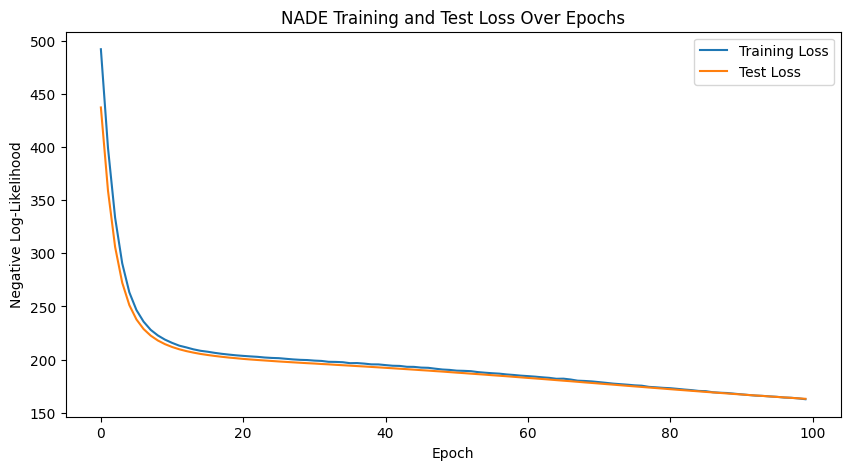

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Negative Log-Likelihood')
plt.legend()
plt.title('NADE Training and Test Loss Over Epochs')
plt.show()

## Save model and results

In [ ]:
NADE_MODEL_PATH = 'nade_model.pth'
print(f"\nSaving NADE model state_dict to {NADE_MODEL_PATH}...")

torch.save(nade.state_dict(), NADE_MODEL_PATH)
print("NADE model saved successfully.")


Saving NADE model state_dict to nade_model.pth...
NADE model saved successfully.


In [8]:
nade = NADE().to(device)

# Load the saved weights into the model instance

nade.load_state_dict(torch.load('nade_model.pth'))

<All keys matched successfully>

In [27]:
import json

In [ ]:
nade_results_to_save = {
    'train_losses': train_losses,
    'test_losses': test_losses,
    'fid_history': fid_history,
    'time_history': time_history,
    'epoch_history': epoch_history
}

NADE_RESULTS_PATH = 'nade_training_results.json'
print(f"\nSaving NADE training results to {NADE_RESULTS_PATH}...")

with open(NADE_RESULTS_PATH, 'w') as f:
    json.dump(nade_results_to_save, f, indent=4)
print("NADE results saved successfully.")


Saving NADE training results to nade_training_results.json...
NADE results saved successfully.


In [28]:
with open('nade_training_results.json', 'r') as f:
    loaded_nade_results = json.load(f)

# Train VAE model

In [ ]:
latent_dim = 20

vae_model = VAE(latent_dim = latent_dim).to(device)
optimizer = optim.Adam(vae_model.parameters(), lr=1e-3)

num_epochs = 100
train_losses_vae = []
test_losses_vae = []

fid_history_vae = []
time_history_vae = []


start_time = time.time()
print("\nStarting VAE training...")

for epoch in range(num_epochs):
    vae_model.train()
    total_train_loss = 0
    for batch, _ in train_loader:
        batch = batch.view(-1, 784).to(device)

        recon_x, mu, log_var = vae_model(batch)

        loss, recon_loss, kl_loss = vae_loss(recon_x, batch, mu, log_var)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader.dataset)
    train_losses_vae.append(avg_train_loss)

    vae_model.eval()
    total_test_loss = 0
    with torch.no_grad():
        for batch, _ in test_loader:
            batch = batch.view(-1, 784).to(device)
            recon_x, mu, log_var = vae_model(batch)
            loss, _, _ = vae_loss(recon_x, batch, mu, log_var)
            total_test_loss += loss.item()

    avg_test_loss = total_test_loss / len(test_loader.dataset)
    test_losses_vae.append(avg_test_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Train ELBO: {avg_train_loss:.4f} | Test ELBO: {avg_test_loss:.4f}")

    # FID Calculation Every 5 Epochs
    if epoch % 5 == 0:

        vae_model.eval()

        with torch.no_grad():

            z = torch.randn(len(test_images), latent_dim).to(device)

            generated_samples = vae_model.decoder(z)

            generated_samples = generated_samples.view(-1, 1, 28, 28)

            fake_features = classifier(generated_samples, return_features=True).cpu().numpy()

            fid_score = calculate_fid(real_features, fake_features)

            fid_history_vae.append(fid_score)
            elapsed_time = time.time() - start_time
            time_history_vae.append(elapsed_time)

            print(f"--- Epoch {epoch+1} Evaluation ---")
            print(f"FID Score: {fid_score:.4f}")
            print(f"Time Elapsed: {elapsed_time:.2f} seconds")
            print("--------------------------")

print("\nTraining complete!")
print("FID History:", fid_history_vae)
print("Time History:", time_history_vae)


Starting VAE training...
Epoch [1/100] - Train ELBO: 370.4469 | Test ELBO: 236.8273
--- Epoch 1 Evaluation ---
FID Score: 0.0286
Time Elapsed: 0.11 seconds
--------------------------
Epoch [2/100] - Train ELBO: 223.6306 | Test ELBO: 209.0289
Epoch [3/100] - Train ELBO: 208.4051 | Test ELBO: 201.1005
Epoch [4/100] - Train ELBO: 200.7400 | Test ELBO: 195.0349
Epoch [5/100] - Train ELBO: 192.3666 | Test ELBO: 185.9324
Epoch [6/100] - Train ELBO: 184.2036 | Test ELBO: 180.5898
--- Epoch 6 Evaluation ---
FID Score: 0.0288
Time Elapsed: 0.78 seconds
--------------------------
Epoch [7/100] - Train ELBO: 178.6174 | Test ELBO: 174.7469
Epoch [8/100] - Train ELBO: 172.6401 | Test ELBO: 170.7053
Epoch [9/100] - Train ELBO: 168.3206 | Test ELBO: 166.2156
Epoch [10/100] - Train ELBO: 162.7976 | Test ELBO: 160.6509
Epoch [11/100] - Train ELBO: 158.1571 | Test ELBO: 157.1502
--- Epoch 11 Evaluation ---
FID Score: 0.0221
Time Elapsed: 1.42 seconds
--------------------------
Epoch [12/100] - Train EL

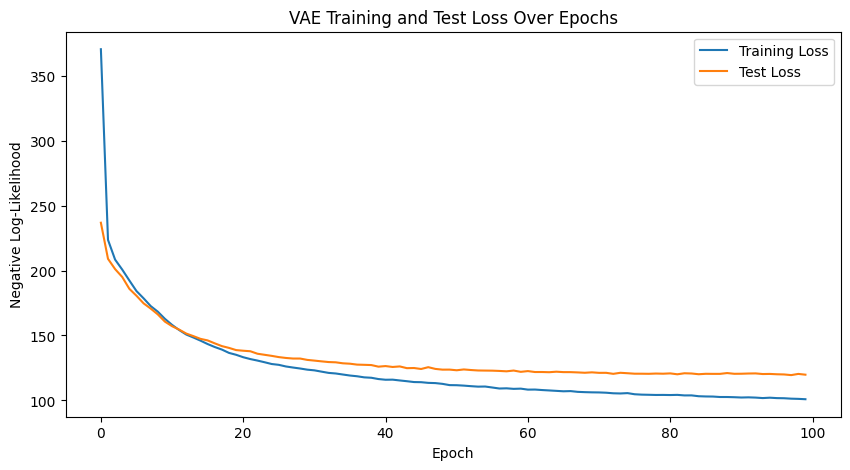

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses_vae, label='Training Loss')
plt.plot(test_losses_vae, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Negative Log-Likelihood')
plt.legend()
plt.title('VAE Training and Test Loss Over Epochs')
plt.show()

In comparison, VAE has converged way faster than NADE.

## Save model and results

In [ ]:
VAE_MODEL_PATH = 'vae_model_latent20.pth'

print(f"\nSaving model state_dict to {VAE_MODEL_PATH}...")
torch.save(vae_model.state_dict(), VAE_MODEL_PATH)
print("Model saved successfully.")


Saving model state_dict to vae_model_latent20.pth...
Model saved successfully.


In [9]:
# Load the saved weights into the model instance

VAE_MODEL_PATH = 'vae_model_latent20.pth'

vae_model = VAE(latent_dim=20).to(device)
vae_model.load_state_dict(torch.load(VAE_MODEL_PATH))

<All keys matched successfully>

In [ ]:
import json

In [ ]:
results = {
    'train_losses': train_losses_vae,
    'test_losses': test_losses_vae,
    'fid_history': fid_history_vae,
    'time_history': time_history_vae
}


RESULTS_PATH = 'vae_training_results.json'

print(f"\nSaving training results to {RESULTS_PATH}...")
with open(RESULTS_PATH, 'w') as f:
    json.dump(results, f, indent=4)
print("Results saved successfully.")


Saving training results to vae_training_results.json...
Results saved successfully.


In [32]:
RESULTS_PATH = 'vae_training_results.json'

with open(RESULTS_PATH, 'r') as f:
    loaded_vae_results = json.load(f)

# Model verification and sample comparison

In [ ]:
vae_model.eval()
nade.eval()

torch.manual_seed(42)
latent_dim = 20
num_samples_to_generate = 1000

with torch.no_grad():
  z = torch.randn(num_samples_to_generate, latent_dim).to(device)
  vae_samples = vae_model.decoder(z)

  nade_samples = nade.generate_samples(num_samples=num_samples_to_generate)

gmm_samples_raw, _ = gmm.sample(num_samples_to_generate)
gmm_samples_np = np.clip(gmm_samples_raw, 0.0, 1.0)
gmm_samples = torch.from_numpy(gmm_samples_np.astype(np.float32))

vae_samples = vae_samples.cpu()
nade_samples = nade_samples.cpu()

print("Sample generation complete.")
print(f"Shape of VAE samples: {vae_samples.shape}")
print(f"Shape of NADE samples: {nade_samples.shape}")
print(f"Shape of GMM samples: {gmm_samples.shape}")

Sample generation complete.
Shape of VAE samples: torch.Size([1000, 784])
Shape of NADE samples: torch.Size([1000, 784])
Shape of GMM samples: torch.Size([1000, 784])


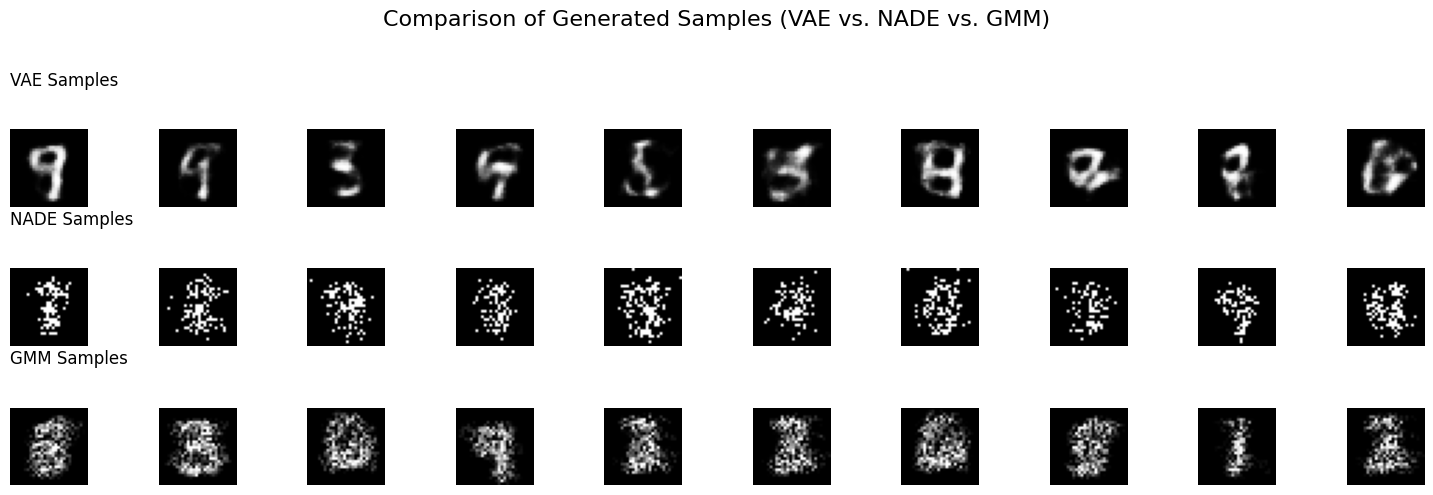

In [ ]:
num_to_display = 10
random_indices = np.random.choice(num_samples_to_generate, num_to_display, replace=False)

fig, axes = plt.subplots(3, num_to_display, figsize=(15, 5))
fig.suptitle('Comparison of Generated Samples (VAE vs. NADE vs. GMM)', fontsize=16)

for i, idx in enumerate(random_indices):
    axes[0, i].imshow(vae_samples[idx].view(28, 28).numpy(), cmap='gray')
    axes[0, i].axis('off')

    axes[1, i].imshow(nade_samples[idx].view(28, 28).numpy(), cmap='gray')
    axes[1, i].axis('off')

    axes[2, i].imshow(gmm_samples[idx].view(28, 28).numpy(), cmap='gray')
    axes[2, i].axis('off')


axes[0, 0].set_title('VAE Samples', loc='left', y=1.2, fontsize=12, pad=20)
axes[1, 0].set_title('NADE Samples', loc='left', y=1.2, fontsize=12, pad=20)
axes[2, 0].set_title('GMM Samples', loc='left', y=1.2, fontsize=12, pad=20)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

#### The NADE samples are not recognizable at all. VAE has generated the most accurate samples. Nevertheless, the samples from VAE are blurry. The samples generated from NADE are too noisy.

# Comparison via IS, FID and KID

In [ ]:
def extract_features(samples, classifier_model, device):
    with torch.no_grad():
        samples_reshaped = samples.view(-1, 1, 28, 28).to(device)
        features = classifier_model(samples_reshaped, return_features=True)
        return features.cpu().numpy()

In [ ]:
classifier.eval()
nade.eval()
vae_model.eval()

real_features = extract_features(test_images, classifier, device)
vae_features = extract_features(vae_samples, classifier, device)
nade_features = extract_features(nade_samples, classifier, device)
gmm_features = extract_features(gmm_samples, classifier, device)
print("Feature extraction complete.")

Feature extraction complete.


In [ ]:
is_vae, is_vae_std = calculate_inception_score(vae_samples, classifier)
is_nade, is_nade_std = calculate_inception_score(nade_samples, classifier)
is_gmm, is_gmm_std = calculate_inception_score(gmm_samples, classifier)

print(f"  - VAE:  {is_vae:.4f} ± {is_vae_std:.4f}")
print(f"  - NADE: {is_nade:.4f} ± {is_nade_std:.4f}")
print(f"  - GMM:  {is_gmm:.4f} ± {is_gmm_std:.4f}")

  - VAE:  1.0000 ± 0.0000
  - NADE: 1.0000 ± 0.0000
  - GMM:  1.0000 ± 0.0000


The inception score (IS) is approximately equal in all three models.

In [ ]:
fid_vae = fid_history_vae[-1]
fid_nade = fid_history[-1]
fid_gmm = calculate_fid(real_features, gmm_features)

print(f"\nFréchet Inception Distance (FID) - Lower is Better:")
print(f"  - VAE:  {fid_vae:.4f}")
print(f"  - NADE: {fid_nade:.4f}")
print(f"  - GMM:  {fid_gmm:.4f}")


Fréchet Inception Distance (FID) - Lower is Better:
  - VAE:  0.0040
  - NADE: 0.0091
  - GMM:  0.0047


VAE's FID score is the lowest (best) and NADE's score is the highest (worst) which is consistent with the previously visualized generated samples.

In [ ]:
kid_vae = calculate_kid_gaussian(real_features, vae_features)
kid_nade = calculate_kid_gaussian(real_features, nade_features)
kid_gmm = calculate_kid_gaussian(real_features, gmm_features)

print(f"\nKernel Inception Distance (KID) - Lower is Better:")
print(f"  - VAE:  {kid_vae:.4f}")
print(f"  - NADE: {kid_nade:.4f}")
print(f"  - GMM:  {kid_gmm:.4f}")


Kernel Inception Distance (KID) - Lower is Better:
  - VAE:  0.0001
  - NADE: 0.0003
  - GMM:  0.0001


Comparing with the KID score, VAE and GMM are equally good and NADE's performance was worse than both of them.

# Diversity & Sparsity

In [ ]:
from scipy.stats import entropy

def calculate_diversity_and_sparsity(samples, classifier, device):
    """
    Calculates the diversity (entropy) and sparsity (KL divergence from uniform)
    of the marginal class distribution p(y).

    Args:
        samples (torch.Tensor): A tensor of generated images (on CPU).
        classifier (nn.Module): A pretrained classifier.
        device: The torch device ('cuda' or 'cpu').

    Returns:
        tuple: (diversity_score, sparsity_score)
    """
    classifier.eval()

    all_preds = []
    dataset = TensorDataset(samples)

    dataloader = DataLoader(dataset, batch_size=256)

    with torch.no_grad():
        for batch in dataloader:
            img_batch = batch[0].view(-1, 1, 28, 28).to(device)
            preds = F.softmax(classifier(img_batch), dim=1)
            all_preds.append(preds.cpu().numpy())

    all_preds = np.concatenate(all_preds, axis=0)
    p_y = np.mean(all_preds, axis=0)


    diversity_score = entropy(p_y)

    num_classes = p_y.shape[0]
    uniform_dist = np.full(num_classes, 1.0 / num_classes)
    sparsity_score = entropy(p_y, qk=uniform_dist) # Calculates KL(p_y || uniform_dist)

    return diversity_score, sparsity_score

In [ ]:
div_vae, sparse_vae = calculate_diversity_and_sparsity(vae_samples, classifier, device)

div_nade, sparse_nade = calculate_diversity_and_sparsity(nade_samples, classifier, device)

div_gmm, sparse_gmm = calculate_diversity_and_sparsity(gmm_samples, classifier, device)

print(f"\nDiversity (Entropy of p(y)) - Higher is Better:")
print(f"  - VAE:  {div_vae:.4f}")
print(f"  - NADE: {div_nade:.4f}")
print(f"  - GMM:  {div_gmm:.4f}")

print(f"\nSparsity (KL Div. from Uniform) - Lower is Better:")
print(f"  - VAE:  {sparse_vae:.4f}")
print(f"  - NADE: {sparse_nade:.4f}")
print(f"  - GMM:  {sparse_gmm:.4f}")


Diversity (Entropy of p(y)) - Higher is Better:
  - VAE:  2.2991
  - NADE: 2.2989
  - GMM:  2.2989

Sparsity (KL Div. from Uniform) - Lower is Better:
  - VAE:  0.0035
  - NADE: 0.0037
  - GMM:  0.0036


NADE and GMM have generated more conservative samples as the observe lower diversity in them. No evidence of risky outliers (e.g., overconfident or highly skewed outputs), at least from class-level statistics.

# Likelihood & Reconstruction

In [33]:
nade.eval()
vae_model.eval()

VAE(
  (encoder): Encoder(
    (enc): Sequential(
      (0): Linear(in_features=784, out_features=400, bias=True)
      (1): ReLU()
    )
    (mu): Linear(in_features=400, out_features=20, bias=True)
    (log_var): Linear(in_features=400, out_features=20, bias=True)
  )
  (decoder): Decoder(
    (dec): Sequential(
      (0): Linear(in_features=20, out_features=400, bias=True)
      (1): ReLU()
      (2): Linear(in_features=400, out_features=784, bias=True)
      (3): Sigmoid()
    )
  )
)

In [34]:
total_log_prob_nade = 0.0
with torch.no_grad():
    for batch, _ in test_loader:
        batch = batch.view(-1, 784).to(device)

        log_prob_batch = nade.log_prob(batch)
        total_log_prob_nade += log_prob_batch.sum().item()

avg_log_likelihood = total_log_prob_nade / len(test_loader.dataset)

# Convert to bits per dimension
nats_to_bits = 1.0 / np.log(2)
num_dimensions = train_images.shape[1]

nll_bits_per_dim = -avg_log_likelihood * nats_to_bits / num_dimensions

print(f"NADE Average Test-Set Negative Log-Likelihood: {nll_bits_per_dim:.4f} bits/dim")

NADE Average Test-Set Negative Log-Likelihood: 0.3001 bits/dim


In [35]:
total_test_elbo_vae = 0.0
with torch.no_grad():
    for batch, _ in test_loader:
        batch = batch.view(-1, 784).to(device)
        recon_x, mu, log_var = vae_model(batch)

        # The `loss` returned here is the negative of the ELBO
        loss, _, _ = vae_loss(recon_x, batch, mu, log_var)
        total_test_elbo_vae += loss.item()

avg_negative_elbo = total_test_elbo_vae / len(test_loader.dataset)

print(f"VAE Average Test-Set Negative ELBO: {avg_negative_elbo:.4f}")

VAE Average Test-Set Negative ELBO: 119.8039


The computation of actual likelihood of data is infeasible in VAE model. Instead we calculate ELBO (evidence lower bound) for it; which is not comparable to the log-likelihood.

# Computational Trade-offs

In [38]:
import matplotlib.pyplot as plt

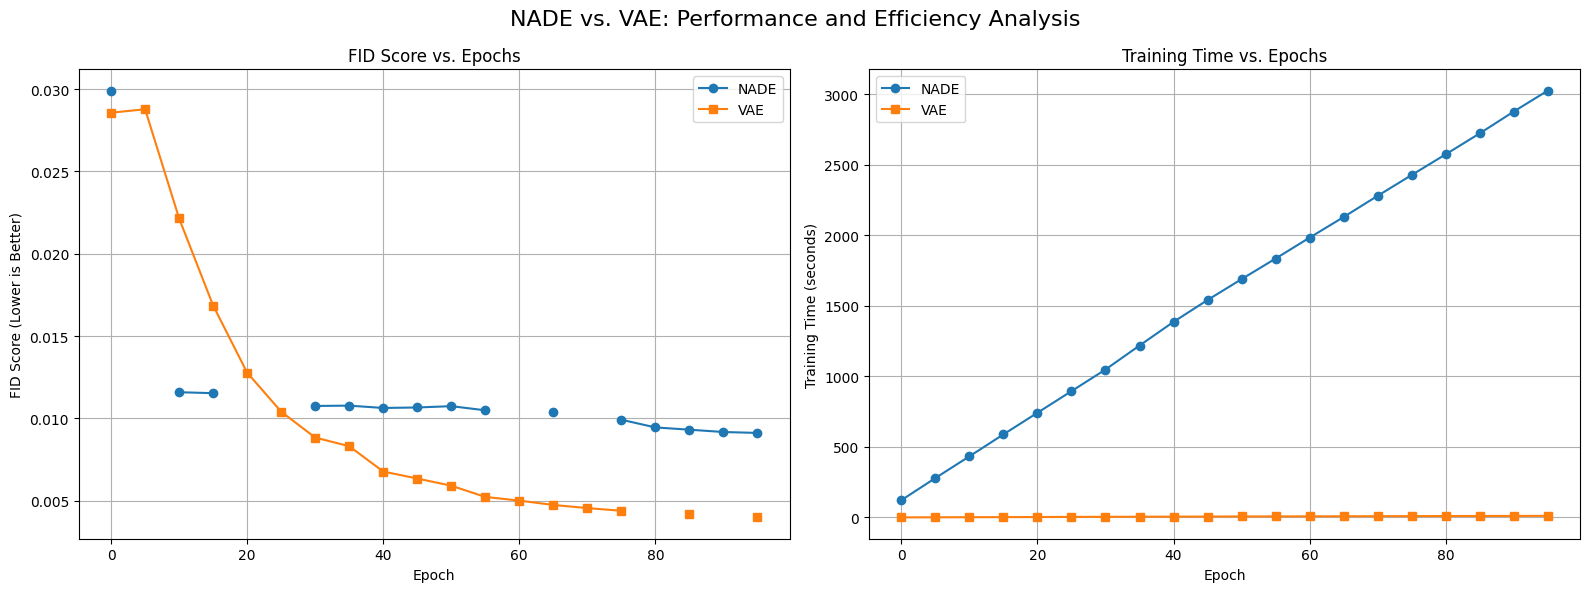

In [44]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

fig.suptitle('NADE vs. VAE: Performance and Efficiency Analysis', fontsize=16)

ax1 = axes[0]
ax1.plot(list(range(0, 100, 5)), loaded_nade_results['fid_history'], marker='o', linestyle='-', label='NADE')
ax1.plot(list(range(0, 100, 5)), loaded_vae_results['fid_history'], marker='s', linestyle='-', label='VAE')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('FID Score (Lower is Better)')
ax1.set_title('FID Score vs. Epochs')
ax1.legend()
ax1.grid(True)

ax2 = axes[1]
ax2.plot(list(range(0, 100, 5)), loaded_nade_results['time_history'], marker='o', linestyle='-', label='NADE')
ax2.plot(list(range(0, 100, 5)), loaded_vae_results['time_history'], marker='s', linestyle='-', label='VAE')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Training Time (seconds)')
ax2.set_title('Training Time vs. Epochs')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

More training has not improved the FID score of NADE model while more epochs resulted in a significant decrease in FID score for VAE. On the other hand, it is obviously extremely cost-inefficient to train NADE for a large number of epochs.

# Sampling Speed

In [10]:
vae_model.eval()

latent_dim = 20
num_samples_batch = 100
num_runs_single = 10 # Number of times to run single-sample generation for averaging

results = {}

with torch.no_grad():
    # Warm-up run
    _ = vae_model.decoder(torch.randn(1, latent_dim).to(device))
    if str(device) == 'cuda':
        torch.cuda.synchronize()

    # Time 1 sample (averaged over several runs)
    start_time = time.time()
    for _ in range(num_runs_single):
        _ = vae_model.decoder(torch.randn(1, latent_dim).to(device))
    if str(device) == 'cuda':
        torch.cuda.synchronize()
    end_time = time.time()
    time_single_vae = (end_time - start_time) / num_runs_single

    # Time 100 samples (batched)
    start_time = time.time()
    _ = vae_model.decoder(torch.randn(num_samples_batch, latent_dim).to(device))
    if str(device) == 'cuda':
        torch.cuda.synchronize()
    end_time = time.time()
    time_batch_vae = end_time - start_time

results['VAE'] = {'single': time_single_vae, 'batch': time_batch_vae}

In [11]:
nade.eval()

num_runs_single = 1

with torch.no_grad():
    # Warm-up run
    _ = nade.generate_samples(num_samples=1)
    if str(device) == 'cuda':
        torch.cuda.synchronize()

    # Time 1 sample (averaged)
    start_time = time.time()
    for _ in range(num_runs_single):
        _ = nade.generate_samples(num_samples=1)
    if str(device) == 'cuda':
        torch.cuda.synchronize()
    end_time = time.time()
    time_single_nade = (end_time - start_time) / num_runs_single

    # Time 100 samples (batched)
    start_time = time.time()
    _ = nade.generate_samples(num_samples=num_samples_batch)
    if str(device) == 'cuda':
        torch.cuda.synchronize()
    end_time = time.time()
    time_batch_nade = end_time - start_time

results['NADE'] = {'single': time_single_nade, 'batch': time_batch_nade}

In [15]:
num_runs_single = 10

start_time = time.time()
for _ in range(num_runs_single):
    _ = gmm.sample(n_samples=1)
end_time = time.time()
time_single_gmm = (end_time - start_time) / num_runs_single

# Time 100 samples (batched)
start_time = time.time()
_ = gmm.sample(n_samples=num_samples_batch)
end_time = time.time()
time_batch_gmm = end_time - start_time
results['GMM'] = {'single': time_single_gmm, 'batch': time_batch_gmm}

In [16]:
print(f"{'Model':<10} | {'Time for 1 Sample (s)':<25} | {'Time for 100 Samples (s)':<25}")
print("-" * 65)
for model_name, times in results.items():
    print(f"{model_name:<10} | {times['single']:<25.6f} | {times['batch']:<25.6f}")

Model      | Time for 1 Sample (s)     | Time for 100 Samples (s) 
-----------------------------------------------------------------
VAE        | 0.000211                  | 0.006496                 
NADE       | 95.588426                 | 98.318010                
GMM        | 0.000598                  | 0.003467                 


As each sample is generated iteratively (via chain rule) in NADE, this model is way slower in sample generation. Caching intermediate computations (especially hidden layer activations) can significantly speed up sampling in NADE.
However, due to the sequential and conditional nature of the model, there is a limit to how much speedup you can get — full parallel sampling isn’t possible.

# Limitations & Ethics Discussion

###  - *If NADE has better FID but VAE trains faster, which would you deploy on a mobile device?*

The superior sample quality (lower FID) of NADE is completely irrelevant if the user has to wait an impractically long time for a single sample. The VAE's ability to generate images almost instantly makes it the only viable choice for a resource-constrained, user-facing environment like a mobile device, where speed and battery efficiency are paramount.
</br></br>

### *- MNIST is grayscale and low-res—how might FID/KID mislead us on CIFAR-10?*

Moving from MNIST to a more complex, colored dataset like CIFAR-10 exposes the limitations of metrics like FID and KID. While still useful, they can be misleading; FID and KID have sensitivity to low-Level statistics over semantics. Also, the metrics are inable to judge object coherence. </br>

On CIFAR-10, a good FID/KID score tells you the model is good at generating images with a similar look and feel to the real data, but it doesn't guarantee that the model can generate coherent, realistic objects.
</br></br>

### - *Could either model’s latent space leak private training data?*

Both models are vulnerable to leaking information about their private training data, a risk addressed by the field of machine learning privacy and security. This is typically done through Model Inversion Attacks.</br>

VAE's latent space is a compressed representation of the data, and the decoder is a powerful tool for turning that representation back into an image. While NADE doesn't have an explicit, low-dimensional latent space like a VAE, it is still at risk. The model's parameters have memorized the entire probability distribution $P(x)$ of the training data.